In [1]:
import matplotlib.pyplot as plt
import itertools
import json
import numpy as np
from pylhe import read_lhe_with_attributes, read_num_events
import itertools
import json
import math
import vector

### Defining Functions

In [2]:
def extract_particle_data(lhe_file, particle_ids):
    
    events = read_lhe_with_attributes(lhe_file)

    num_events = read_num_events(lhe_file)

    particle_data = []


    if not isinstance(particle_ids, list):
        particle_ids = [particle_ids] 


    for event_index, event in enumerate(itertools.islice(events, num_events)):
        for particle in event.particles:

            if particle.id in particle_ids:  
                particle_data.append({
                    'event': event_index,
                    'id': particle.id,
                    'px': particle.px,
                    'py': particle.py,
                    'pz': particle.pz,
                    'E': particle.e,
                    'status': particle.status
                })

    return particle_data

def extract_kinematic_data(particle_data):
    kinematic_data = []


    for particle in particle_data:
        px, py, pz = particle['px'], particle['py'], particle['pz']


        pt = math.sqrt(px**2 + py**2)


        phi = math.atan2(py, px)


        theta = math.acos(pz / math.sqrt(px**2 + py**2 + pz**2))
        eta = -math.log(math.tan(theta / 2))


        kinematic_data.append({
            'pt': pt,
            'eta': eta,
            'phi': phi,
        })

    return kinematic_data


### Validation Functions

In [3]:
def invariant_mass_check(vector_1, vector_2):
    inv_masss_1 = vector_1.E**2 - ( vector_1.px**2 + vector_1.py**2 + vector_1.pz**2 )
    inv_masss_2 = vector_2.E**2 - ( vector_2.px**2 + vector_2.py**2 + vector_2.pz**2 )

    mass_diff = np.isclose(inv_masss_1, inv_masss_2, atol=1e-7)
    
    if np.all(mass_diff):
        return

    else:
        changed_indices = np.where(~mass_diff)[0]
        for idx in changed_indices:
            print(f"Warning: Invariant mass changed at index {idx}! Initial: {vector_1.mass[idx]}, Final: {vector_2.mass[idx]}")
    
    return
def momentum_conservation_check(muon_vector, anti_muon_vector):

    total_px = muon_vector.px + anti_muon_vector.px
    total_py = muon_vector.py + anti_muon_vector.py
    total_pz = muon_vector.pz + anti_muon_vector.pz

    px_check = np.isclose(total_px, 0, atol=1e-5)
    py_check = np.isclose(total_py, 0, atol=1e-5)
    pz_check = np.isclose(total_pz, 0, atol=1e-5)

    # Check for px
    if np.all(px_check):
        return
    else:
        failed_indices = np.where(~px_check)[0]
        for idx in failed_indices:
            print(f"Warning: Total px failed at index {idx}: Value = {total_px[idx]}")

    # Check for py
    if np.all(py_check):
        return
    else:
        failed_indices = np.where(~py_check)[0]
        for idx in failed_indices:
            print(f"Warning: Total py failed at index {idx}: Value = {total_py[idx]}")

    # Check for pz
    if np.all(pz_check):
        return
    else:
        failed_indices = np.where(~pz_check)[0]
        for idx in failed_indices:
            print(f"Warning: Total pz failed at index {idx}: Value = {total_pz[idx]}")

    # Final summary
    overall_passed = np.all(px_check) and np.all(py_check) and np.all(pz_check)
    if overall_passed:
        return
    else:
        print("Momentum conservation check failed.")

    return overall_passed

def rotation_check(original_vector, rotated_vector, rotation_axis, tolerance=1e-7):


    # Normalize the rotation axis
    rotation_axis_norm = abs(rotation_axis)
    if rotation_axis_norm < tolerance:
        print("The rotation axis is too small or zero.")
        return False

    rotation_axis_normalized = [
        rotation_axis.px / rotation_axis_norm,
        rotation_axis.py / rotation_axis_norm,
        rotation_axis.pz / rotation_axis_norm
    ]

    # Normalize original and rotated vectors
    original_norm = abs(original_vector)
    rotated_norm = abs(rotated_vector)

    # Check if both vectors are non-zero
    if np.all(original_norm < tolerance) or np.all(rotated_norm < tolerance):
        print("One of the vectors is too small or zero.")
        return False

    # Get the angle between the original and rotated vectors using the dot product
    dot_product = (rotation_axis.px * rotated_vector.px +
                   rotation_axis.py * rotated_vector.py +
                   rotation_axis.pz * rotated_vector.pz)

    angle = np.arccos(dot_product / (rotation_axis_norm * rotated_norm))
    angle_deg = np.degrees(angle)

    # Check the angle to determine if the rotation is correct
    # The expected angle depends on your application; you can set it or calculate it based on the specific rotation
    expected_angle_1 = np.full(angle_deg.shape, 0)  # Same size as angle_deg
    expected_angle_2 = np.full(angle_deg.shape, 180.0)  # Same size as angle_deg

    
    angle_diff_1 = np.isclose(angle_deg, expected_angle_1, atol=tolerance)
    angle_diff_2 = np.isclose(angle_deg, expected_angle_2, atol=tolerance)
    combined_angle_diff = np.logical_or(angle_diff_1, angle_diff_2)


    if np.all(combined_angle_diff):
        return

    else:
        changed_indices = np.where(~combined_angle_diff)[0]
        for idx in changed_indices:
            print(f"Warning: Rotation check failed at Index {idx}."
              f"Calculated angle: {angle_deg[idx]} degrees.")




In [4]:
def contruct_four_vector(data_set):

    four_vector = vector.array({"E": [data["E"] for data in data_set], 
                                "px": [data["px"] for data in data_set], 
                                "py": [data["py"] for data in data_set], 
                                "pz": [data["pz"] for data in data_set]})
    
    return four_vector

def construct_three_momentum(four_vector):

    three_momentum = vector.array({"px": four_vector.px, 
                                   "py": four_vector.py, 
                                   "pz": four_vector.pz})
    return three_momentum

def find_decay_angle(four_vector):
    cos_theta =  four_vector.pz / np.sqrt(four_vector.px**2 + four_vector.py**2 + four_vector.pz**2)
    theta = np.arccos(cos_theta)

    return theta

### Boost Function

In [5]:
def boost_vector(affected_vector, reference_vector):
    
    beta = reference_vector.pz / reference_vector.E
    gamma = 1 / np.sqrt(1 - beta**2)

    E_boosted = gamma * (affected_vector.E - beta*affected_vector.pz)
    pz_boosted = gamma * (affected_vector.pz - beta * affected_vector.E )
    px_boosted = affected_vector.px
    py_boosted = affected_vector.py

    boosted_vector = vector.array({"E": E_boosted, "px": px_boosted, "py": py_boosted,"pz": pz_boosted}) 

    return boosted_vector

### Rotation Function using one angle and an arbitrary axis

In [6]:
def rotate_vector(affected_vector, rotation_axes, rotation_angles):

    rotated_x = np.array(
        (np.cos(rotation_angles) + (1 - np.cos(rotation_angles)) * rotation_axes.x**2) * affected_vector.x +
        (rotation_axes.x * rotation_axes.y * (1 - np.cos(rotation_angles))) * affected_vector.y +
        rotation_axes.y * np.sin(rotation_angles) * affected_vector.z
    )
    
    rotated_y = np.array(
        rotation_axes.px * rotation_axes.py * (1 - np.cos(rotation_angles)) * affected_vector.px +
        (np.cos(rotation_angles) + (1 - np.cos(rotation_angles)) * rotation_axes.py**2) * affected_vector.py -
        rotation_axes.px * np.sin(rotation_angles) * affected_vector.z
    )
        
    rotated_z = np.array(
        -rotation_axes.py * np.sin(rotation_angles) * affected_vector.px +
        rotation_axes.px * np.sin(rotation_angles) * affected_vector.py +
        np.cos(rotation_angles) * affected_vector.z
    )

    rotated_vector = vector.array({"E": affected_vector.E, "px": rotated_x, "py": rotated_y,"pz": rotated_z}) 

    return rotated_vector


def rotate_and_boost(affected_vector, reference_vector, axis):

    # Define Three Vectors
    affected_three_vector = construct_three_momentum(affected_vector)
    reference_three_vector = construct_three_momentum(reference_vector)

    # Finding Rotaton Axes and Angles
    rotation_axes = reference_three_vector.cross(axis).unit()
    cos_theta = reference_three_vector.dot(axis) / abs(reference_three_vector) * abs(axis)
    rotation_angles = np.arccos(cos_theta)

    # Rotate reference vector
    rotated_reference_four_vector = rotate_vector(reference_vector, rotation_axes, rotation_angles)
    rotated_reference_three_vector = vector.array({"px": rotated_reference_four_vector.px, "py": rotated_reference_four_vector.py,"pz": rotated_reference_four_vector.pz}) 
    invariant_mass_check(reference_vector, rotated_reference_four_vector)
    rotation_check(reference_three_vector, rotated_reference_three_vector, axis)

    # Rotate affected vector
    rotated_affected_four_vector = rotate_vector(affected_vector, rotation_axes, rotation_angles)
    rotated_affected_three_vector = vector.array({"px": rotated_affected_four_vector.px, "py": rotated_affected_four_vector.py,"pz": rotated_affected_four_vector.pz}) 
    invariant_mass_check(affected_vector, rotated_affected_four_vector)

    # Boost the affected vector
    rotated_boosted_affected_vector = boost_vector(rotated_affected_four_vector, rotated_reference_four_vector )
    invariant_mass_check(rotated_affected_four_vector, rotated_boosted_affected_vector)

    return rotated_boosted_affected_vector


### Rotation Function Using two Rotations for the azimuthal and polar angle  

In [7]:
def rotation_x(theta, vec):
    rotated_px = vec.px
    rotated_py = vec.py * np.cos(theta) - vec.pz * np.sin(theta)
    rotated_pz = vec.py * np.sin(theta) + vec.pz * np.cos(theta)
    return vector.array(px=rotated_px, py=rotated_py, pz=rotated_pz)

def rotation_y(theta, vec):
    rotated_px = vec.px * np.cos(theta) + vec.pz * np.sin(theta)
    rotated_py = vec.py
    rotated_pz = -vec.px * np.sin(theta) + vec.pz * np.cos(theta)
    return vector.array({"E": vec.E, "px": rotated_px, "py": rotated_py, "pz": rotated_pz})

def rotation_z(phi, vec):
    rotated_px = vec.px * np.cos(phi) - vec.py * np.sin(phi)
    rotated_py = vec.px * np.sin(phi) + vec.py * np.cos(phi)
    rotated_pz = vec.pz
    return vector.array({"E": vec.E, "px": rotated_px, "py": rotated_py, "pz": rotated_pz})

# Function to align a vector with the z-axis
def align_with_z(affected_vector, reference_vector):
    # Calculate spherical coordinates
    r = np.sqrt(reference_vector.px**2 + reference_vector.py**2 + reference_vector.pz**2) # Magnitude of the vector
    theta = np.arccos(reference_vector.pz / r)  # Polar angle
    phi = np.arctan2(reference_vector.py, reference_vector.px)  # Azimuthal angle
    
    # Apply rotations
    reference_vector_rotated_z = rotation_z(-phi, reference_vector)  # Rotate around z-axis by -phi
    rotated_reference_vector = rotation_y(-theta, reference_vector_rotated_z)  # Rotate around y-axis by -theta
    affected_vector_rotated_z = rotation_z(-phi, affected_vector)
    rotated_affected_vector = rotation_y(-theta, affected_vector_rotated_z)
    
    return rotated_affected_vector, rotated_reference_vector


def rotate_and_boost2(affected_vector, reference_vector, axis):

    # Define Three Vectors
    affected_three_vector = construct_three_momentum(affected_vector)
    reference_three_vector = construct_three_momentum(reference_vector)

    # Rotate reference vector
    rotated_affected_four_vector, rotated_reference_four_vector = align_with_z(affected_vector, reference_vector)
    invariant_mass_check(reference_vector, rotated_reference_four_vector)

    # Rotate affected vector
    invariant_mass_check(affected_vector, rotated_affected_four_vector)

    # Boost the affected vector
    rotated_boosted_affected_vector = boost_vector(rotated_affected_four_vector, rotated_reference_four_vector )
    invariant_mass_check(rotated_affected_four_vector, rotated_boosted_affected_vector)

    return rotated_boosted_affected_vector

### Plotting functions

### Plotting functions

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep

def plot_histogram(data, title, file_name):
    luminosity = 100000 / 3.3917389499999996e-05
    
    # Filter out NaN and infinite values
    valid_data = data[np.isfinite(data)]
    
    # Calculate cos(theta) and valid theta values
    theta_data = valid_data
    cos_theta_data = np.cos(valid_data)

    # Count valid events
    num_valid_events = len(valid_data)
    print(f"Number of valid events (not NaN or Inf): {num_valid_events}")

    # Create histogram bins for theta and cos(theta)
    theta_bins = np.linspace(np.min(valid_data), np.max(valid_data), 100)
    cos_theta_bins = np.linspace(-1, 1, 100)

    # Use HEP style without ATLAS branding
    plt.style.use(hep.style.ATLAS)  # This applies the general ATLAS style

    # Set up the figure and two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    fig.subplots_adjust(wspace=0.3)  # Increase space between subplots

    # Plot differential cross section with respect to theta using hist
    ax1.hist(theta_data, bins=theta_bins, color='green', edgecolor='black', alpha=0.7, 
              weights=np.ones(len(theta_data)) / (luminosity * (theta_bins[1] - theta_bins[0])), 
              label=r'$\frac{d\sigma}{d\theta}$')
    ax1.set_xlabel('Angle (radians)', fontsize=14)
    ax1.set_ylabel(r'$\frac{d\sigma}{d\theta}$ ', fontsize=14)
    ax1.set_title(f"{title} - Differential Cross Section w.r.t Angle", fontsize=16, pad=20)
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Plot differential cross section with respect to cos(theta) using hist
    ax2.hist(cos_theta_data, bins=cos_theta_bins, color='blue', edgecolor='black', alpha=0.7, 
              weights=np.ones(len(cos_theta_data)) / (luminosity * (cos_theta_bins[1] - cos_theta_bins[0])), 
              label=r'$\frac{d\sigma}{d(\cos \theta)}$')
    ax2.set_xlabel(r'cos($\theta$)', fontsize=14)
    ax2.set_title(f"{title} - Differential Cross Section w.r.t cos($\\theta$)", fontsize=16, pad=20)
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Display event information
    ax1.text(0.75, 0.9, f'Valid Events: {num_valid_events}', 
             ha='right', va='top', transform=ax1.transAxes, fontsize=12)
    
    # Center-of-mass energy label
    fig.text(0.75, 0.94, r'$\sqrt{s} = 13 \,\mathrm{TeV}$', 
             ha='center', va='top', fontsize=12, color="black")

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top for center-of-mass energy

    # Save the plot
    save_path = rf"C:\Users\gabri\OneDrive\Documents\University\Mphys\TriBoson\Week4\Plots\Polarity\{file_name}.png"
    plt.savefig(save_path, dpi=300)
    plt.show()

    return


### Importing Data

In [9]:
lhe_file = r"C:\Users\gabri\OneDrive\Documents\University\Mphys\TriBoson\Week4\unweighted_events(100000).lhe"

z_data = extract_particle_data(lhe_file, particle_ids=[23])
muon_data = extract_particle_data(lhe_file, particle_ids=[13])
anti_muon_data = extract_particle_data(lhe_file, particle_ids=[-13])

w_data = extract_particle_data(lhe_file, particle_ids=[24])
electron_neutrino_data = extract_particle_data(lhe_file, particle_ids=[12])
anti_electron_data = extract_particle_data(lhe_file, particle_ids=[-11])

w_anti_data = extract_particle_data(lhe_file, particle_ids=[-24])
electron_data = extract_particle_data(lhe_file, particle_ids=[11])
anti_electron_neutrino_data = extract_particle_data(lhe_file, particle_ids=[-12])

### Creaing Four-Vectors

In [10]:
z_four_momentum = contruct_four_vector(z_data)
muon_four_momentum = contruct_four_vector(muon_data)
anti_muon_four_momentum = contruct_four_vector(anti_muon_data)

w_four_momentum = contruct_four_vector(w_data)
electron_neutrino_four_momentum = contruct_four_vector(electron_neutrino_data)
anti_electron_four_momentum = contruct_four_vector(anti_electron_data)

w_anti_four_momentum = contruct_four_vector(w_anti_data)
electron_four_momentum = contruct_four_vector(electron_data)
anti_electron_neutrino_four_momentum = contruct_four_vector(anti_electron_neutrino_data)

com_four_momentum = z_four_momentum + w_four_momentum + w_anti_four_momentum

### Boosting all particles into Z frame 

In [11]:
z_axis = vector.obj(px=0, py=0, pz=1)

z_four_momentum_com = rotate_and_boost(z_four_momentum, com_four_momentum, z_axis)
muon_four_momentum_com = rotate_and_boost(muon_four_momentum, com_four_momentum, z_axis)
anti_muon_four_momentum_com = rotate_and_boost(anti_muon_four_momentum, com_four_momentum, z_axis)


w_four_momentum_com = rotate_and_boost(w_four_momentum, com_four_momentum, z_axis)
electron_neutrino_four_momentum_com = rotate_and_boost(electron_neutrino_four_momentum, com_four_momentum, z_axis)
anti_electron_four_momentum_com = rotate_and_boost(anti_electron_four_momentum, com_four_momentum, z_axis)

w_anti_four_momentum_com = rotate_and_boost(w_anti_four_momentum, com_four_momentum, z_axis)
electron_four_momentum_com = rotate_and_boost(electron_four_momentum, com_four_momentum, z_axis)
anti_electron_neutrino_four_momentum_com = rotate_and_boost(anti_electron_neutrino_four_momentum, com_four_momentum, z_axis)


In [12]:

z_axis = vector.obj(px=0, py=0, pz=1)

z_four_momentum_com_2 = rotate_and_boost2(z_four_momentum, com_four_momentum, z_axis)
muon_four_momentum_com_2 = rotate_and_boost2(muon_four_momentum, com_four_momentum, z_axis)
anti_muon_four_momentum_com_2 = rotate_and_boost2(anti_muon_four_momentum, com_four_momentum, z_axis)


w_four_momentum_com_2 = rotate_and_boost2(w_four_momentum, com_four_momentum, z_axis)
electron_neutrino_four_momentum_com_2 = rotate_and_boost2(electron_neutrino_four_momentum, com_four_momentum, z_axis)
anti_electron_four_momentum_com_2 = rotate_and_boost2(anti_electron_four_momentum, com_four_momentum, z_axis)

w_anti_four_momentum_com_2 = rotate_and_boost2(w_anti_four_momentum, com_four_momentum, z_axis)
electron_four_momentum_com_2 = rotate_and_boost2(electron_four_momentum, com_four_momentum, z_axis)
anti_electron_neutrino_four_momentum_com_2 = rotate_and_boost2(anti_electron_neutrino_four_momentum, com_four_momentum, z_axis)


### Boosting Z decay products into Z Rest Frame

In [13]:
muon_four_momentum_z_rest = rotate_and_boost(muon_four_momentum_com, z_four_momentum_com, z_axis)
muon_angles= find_decay_angle(muon_four_momentum_z_rest)

anti_muon_four_momentum_z_rest = rotate_and_boost(anti_muon_four_momentum_com, z_four_momentum_com, z_axis)
anti_muon_angles = find_decay_angle(anti_muon_four_momentum_z_rest)

momentum_conservation_check(muon_four_momentum_z_rest, anti_muon_four_momentum_z_rest)

In [14]:
muon_four_momentum_z_rest_2 = rotate_and_boost2(muon_four_momentum_com_2, z_four_momentum_com_2, z_axis)
muon_angles_2= find_decay_angle(muon_four_momentum_z_rest_2)

anti_muon_four_momentum_z_rest_2 = rotate_and_boost2(anti_muon_four_momentum_com_2, z_four_momentum_com_2, z_axis)
anti_muon_angles_2 = find_decay_angle(anti_muon_four_momentum_z_rest_2)

momentum_conservation_check(muon_four_momentum_z_rest_2, anti_muon_four_momentum_z_rest_2)

Number of valid events (not NaN or Inf): 100000


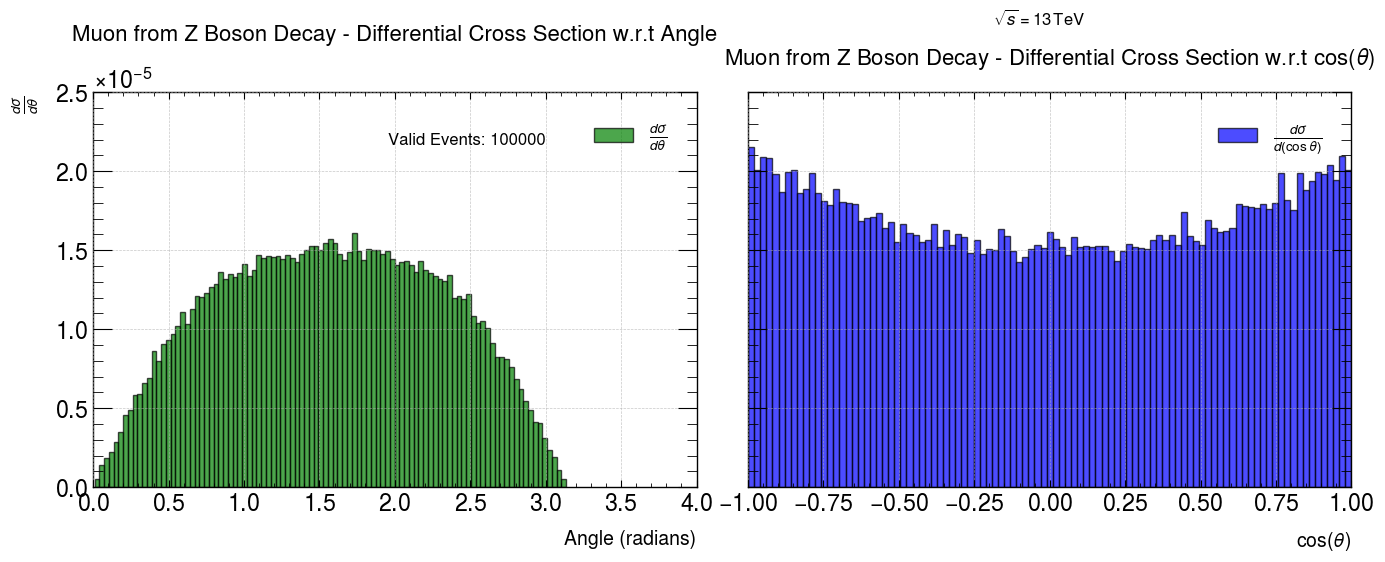

Number of valid events (not NaN or Inf): 100000


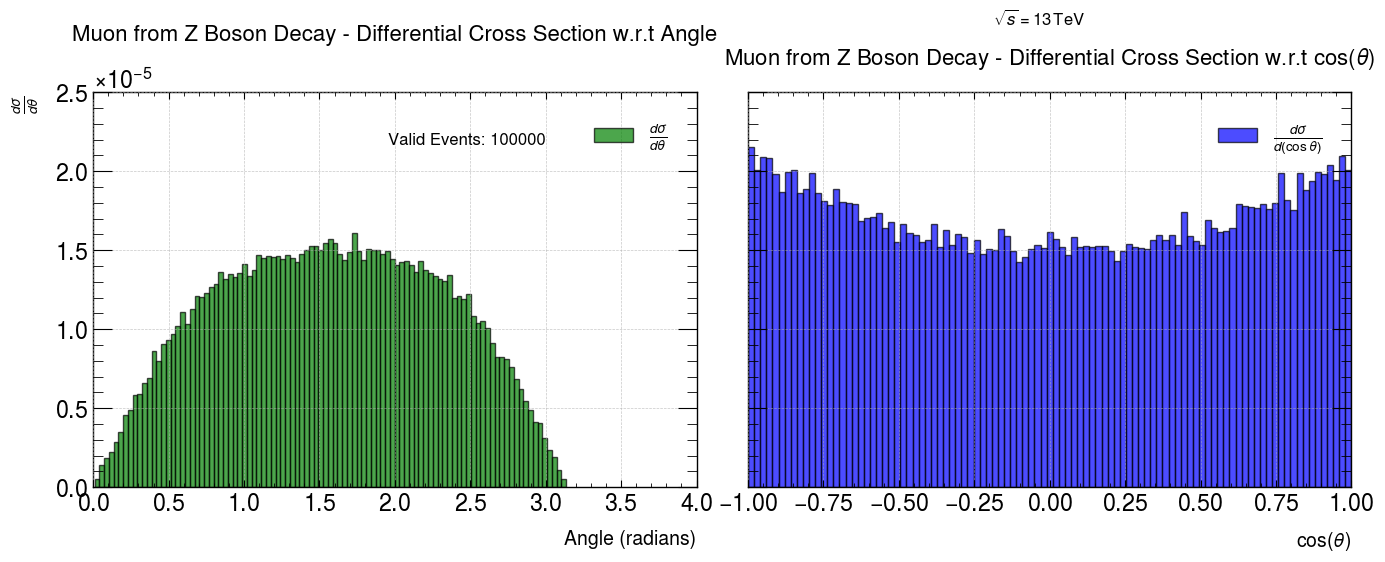

In [15]:
plot_histogram(muon_angles, "Muon from Z Boson Decay", "Polarity ZBoson (muon)")

plot_histogram(muon_angles_2, "Muon from Z Boson Decay", "Polarity ZBoson (muon) ")

### Boosting $W^+$ decay products into $W^+$ Rest Frame


In [16]:
electron_neutrino_four_momentum_w_rest = rotate_and_boost(electron_neutrino_four_momentum_com, w_four_momentum_com, z_axis)
electron_neutrino_angles= find_decay_angle(electron_neutrino_four_momentum_w_rest)

anti_electron_four_momentum_z_rest = rotate_and_boost(anti_electron_four_momentum_com, w_four_momentum_com, z_axis)
anti_electron_angles = find_decay_angle(anti_electron_four_momentum_z_rest)

momentum_conservation_check(electron_neutrino_four_momentum_w_rest, anti_electron_four_momentum_z_rest)

Number of valid events (not NaN or Inf): 100000


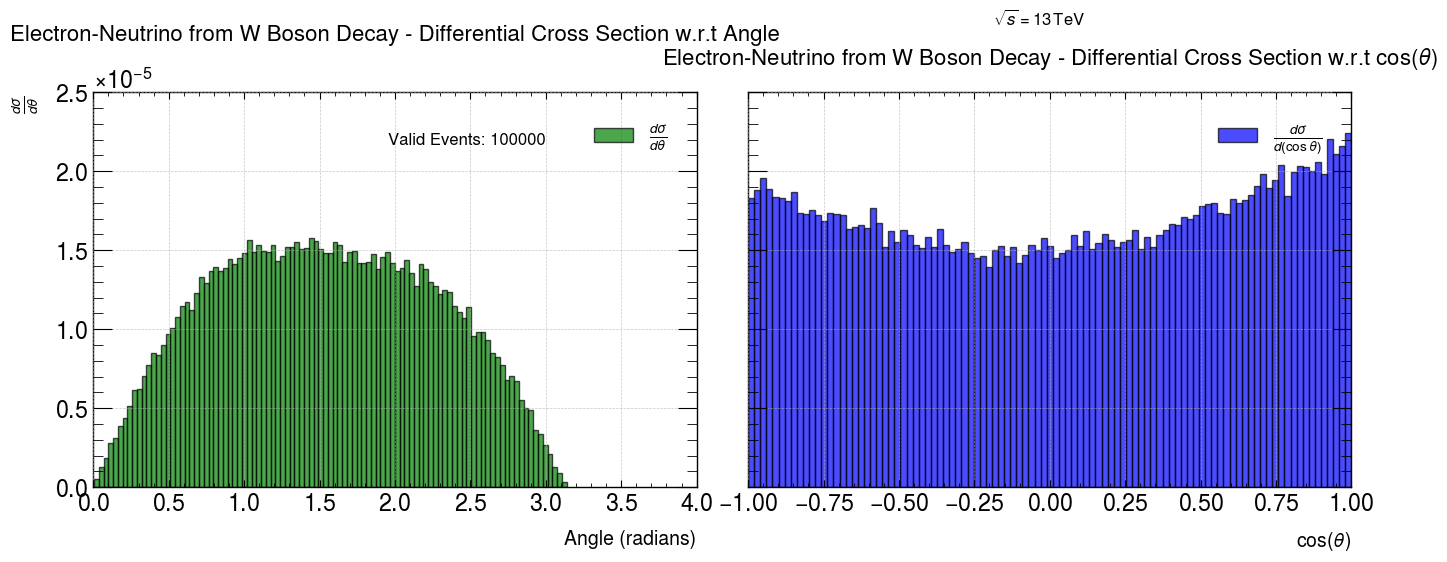

Number of valid events (not NaN or Inf): 100000


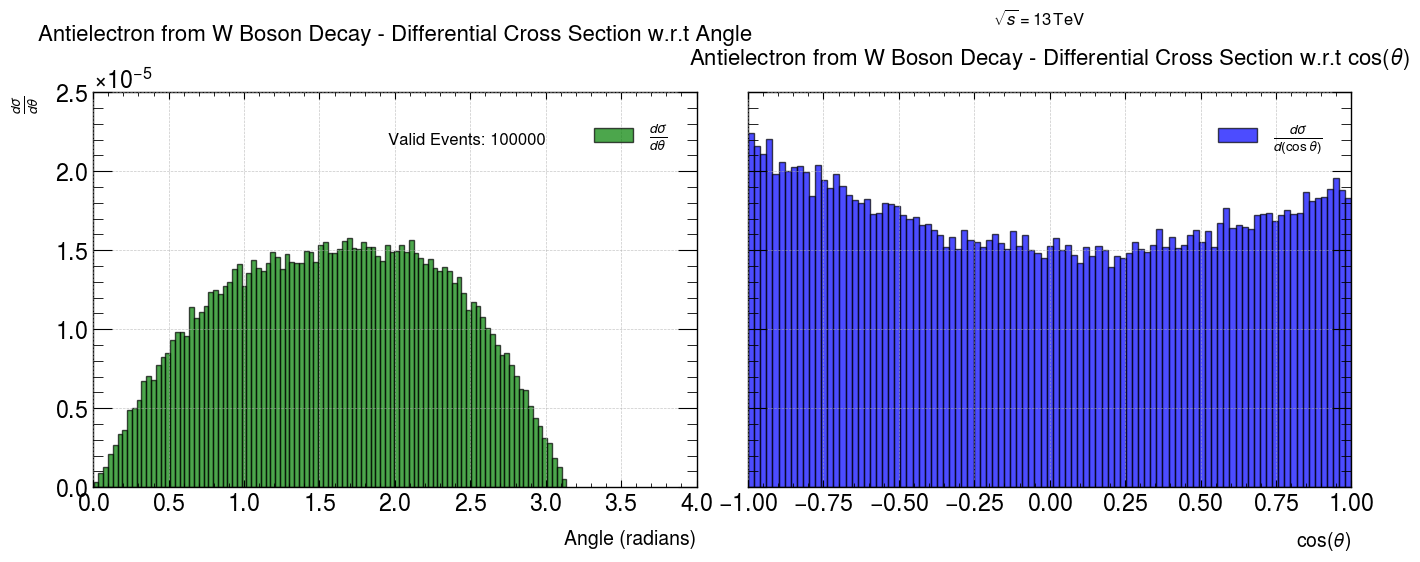

In [17]:
plot_histogram(electron_neutrino_angles, "Electron-Neutrino from W Boson Decay", "Polarity WBoson (Electron Neutrino)")
plot_histogram(anti_electron_angles, "Antielectron from W Boson Decay", "Polarity WBoson (Antielectron)")


### Boosting $W^-$ decay products into $W^-$ Rest Frame


In [18]:
anti_electron_neutrino_four_momentum_w_rest = rotate_and_boost(anti_electron_neutrino_four_momentum_com, w_anti_four_momentum_com, z_axis)
anti_electron_neutrino_angles= find_decay_angle(anti_electron_neutrino_four_momentum_w_rest)

electron_four_momentum_z_rest = rotate_and_boost(electron_four_momentum_com, w_anti_four_momentum_com, z_axis)
electron_angles = find_decay_angle(electron_four_momentum_z_rest)

Number of valid events (not NaN or Inf): 100000


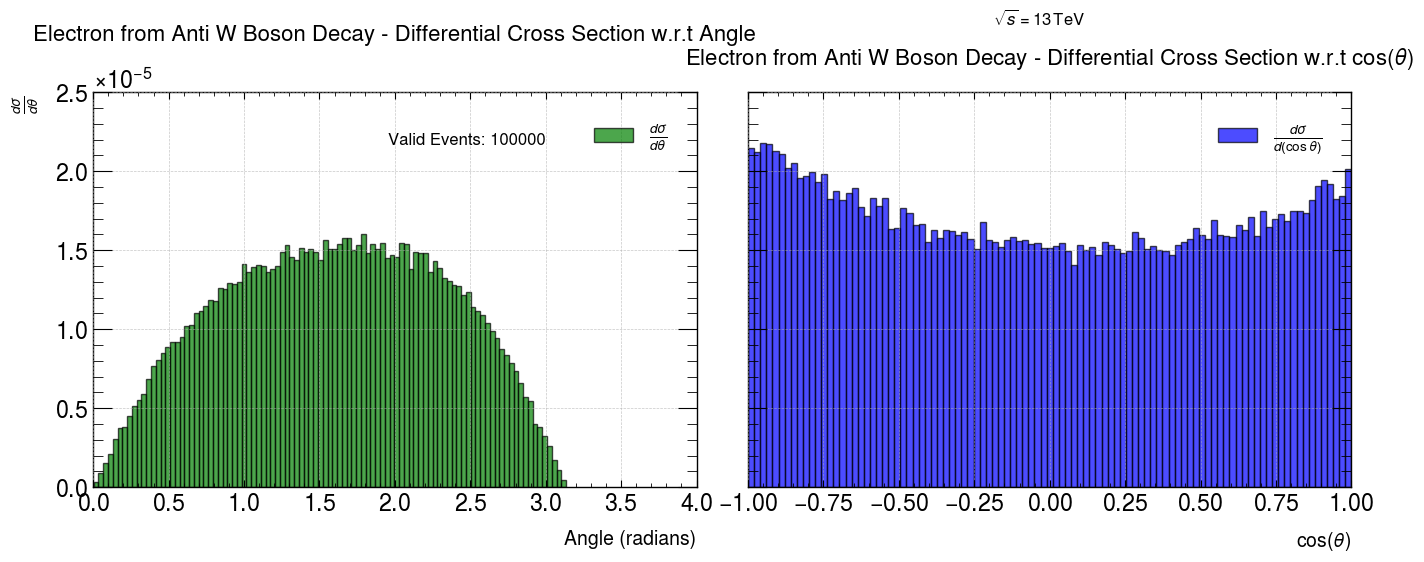

Number of valid events (not NaN or Inf): 100000


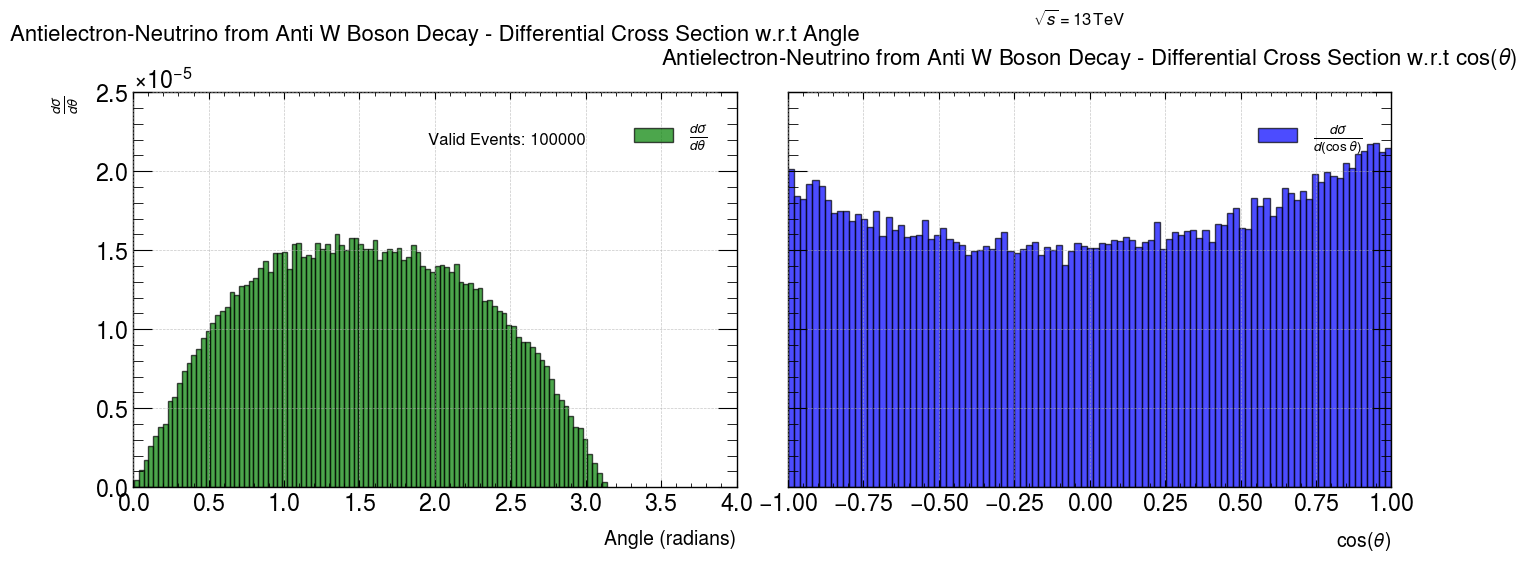

In [19]:
plot_histogram(electron_angles, "Electron from Anti W Boson Decay", "Polarity Anti WBoson (Electron)")
plot_histogram(anti_electron_neutrino_angles, "Antielectron-Neutrino from Anti W Boson Decay", "Polarity Anti WBoson (Anti Electron-Neutrino)")

In [20]:
def z_helicity_function(cos_theta, fL, fR, f0):
    cv = -1/2 + 2* np.sin(0.23152)**2
    ca = -1/2
    alpha = (2*cv*ca)/ (cv**2+ca**2)
    """The fitting function with the provided equation."""
    term1 = (3/8) * fL * (1 + 2 * alpha * cos_theta + cos_theta**2)
    term2 = (3/8) * fR * (1 + cos_theta**2 - 2 * alpha * cos_theta)
    term3 = (3/4) * f0 * (1 - cos_theta**2)
    return term1 + term2 + term3

def w_helicity_function(cos_theta, fL, fR, f0):
    term1 = (3/8) * fL * (1 - cos_theta)**2
    term2 = (3/8) * fR * (1 + cos_theta)**2
    term3 = (3/4) * f0 * (1-cos_theta**2)  
    return term1 + term2 + term3

def anti_w_helicity_function(cos_theta, fL, fR, f0):
    term1 = (3/8) * fL * (1 + cos_theta)**2
    term2 = (3/8) * fR * (1 - cos_theta)**2
    term3 = (3/4) * f0 * (1-cos_theta**2)  
    return term1 + term2 + term3

In [21]:
def calculate_reduced_chi_squared(observed_values, expected_values, error, degrees_of_freedom):
    chi_squared = np.sum(((observed_values - expected_values) ** 2) / error**2)
    reduced_chi_squared = chi_squared / degrees_of_freedom
    return reduced_chi_squared

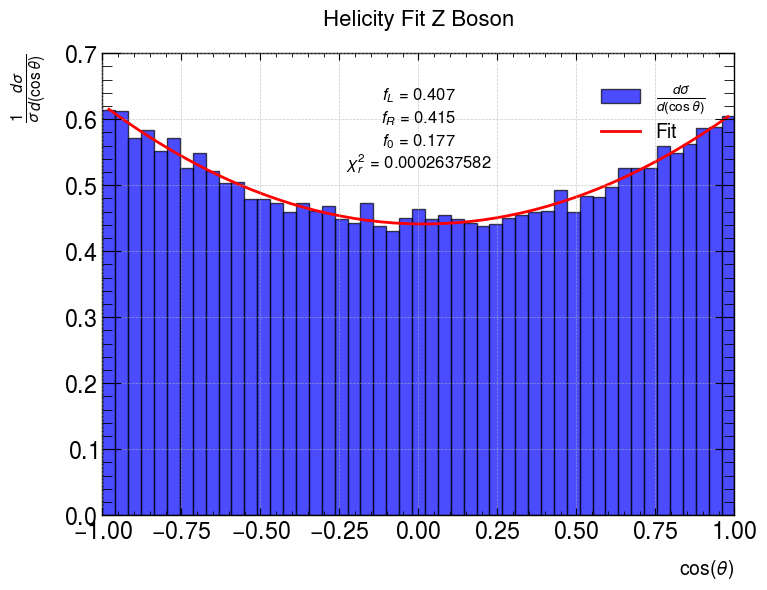

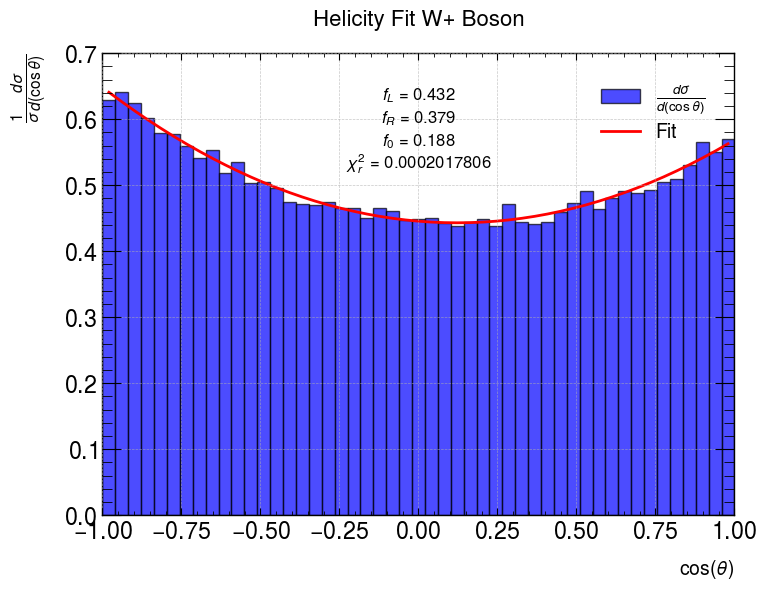

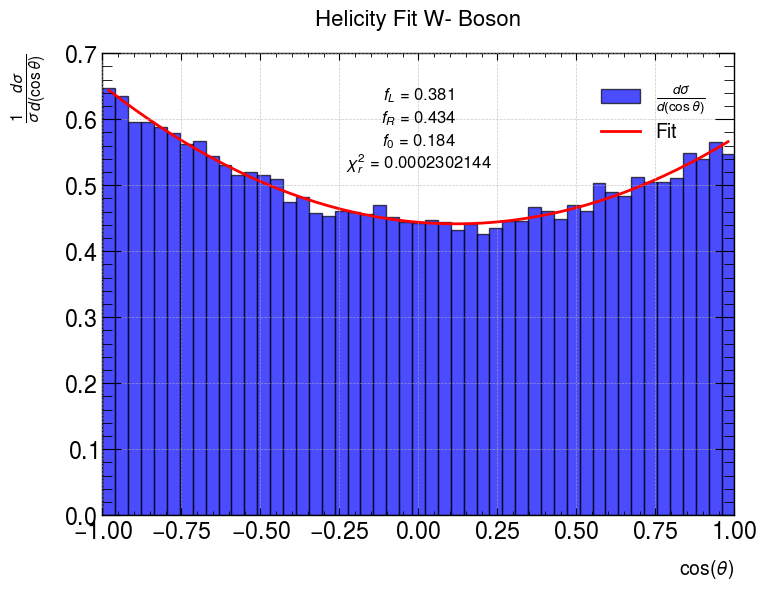

In [22]:
from scipy.optimize import curve_fit
def z_helicity_function(cos_theta, fL, fR, f0):
    cv = -1/2 + 2* np.sin(0.23152)**2
    ca = -1/2
    alpha = (2*cv*ca)/ (cv**2+ca**2)
    """The fitting function with the provided equation."""
    term1 = (3/8) * fL * (1 + 2 * alpha * cos_theta + cos_theta**2)
    term2 = (3/8) * fR * (1 + cos_theta**2 - 2 * alpha * cos_theta)
    term3 = (3/4) * f0 * (1 - cos_theta**2)
    return term1 + term2 + term3

def w_helicity_function(cos_theta, fL, fR, f0):
    term1 = (3/8) * fL * (1 - cos_theta)**2
    term2 = (3/8) * fR * (1 + cos_theta)**2
    term3 = (3/4) * f0 * (1-cos_theta**2)  
    return term1 + term2 + term3

def anti_w_helicity_function(cos_theta, fL, fR, f0):
    term1 = (3/8) * fL * (1 + cos_theta)**2
    term2 = (3/8) * fR * (1 - cos_theta)**2
    term3 = (3/4) * f0 * (1-cos_theta**2)  
    return term1 + term2 + term3

def calculate_helicity_fractions(data, boson_type, title, file_name):
    """Plots the differential cross section histogram for the boson."""
    luminosity = 100000 / 3.3917389499999996e-05

    # Filter out NaN and infinite values
    valid_data = data[np.isfinite(data)]
    cos_theta_data = np.cos(valid_data)
    cos_theta_bins = np.linspace(-1, 1, 50)

    plt.style.use(hep.style.ATLAS)
    plt.figure(figsize=(8, 6))

    # Plot histogram for differential cross section w.r.t cos(theta)
    hist_values, bins, _ = plt.hist(cos_theta_data, bins=cos_theta_bins, color='blue', edgecolor='black', alpha=0.7,
                                    weights=np.ones(len(cos_theta_data)) / (luminosity * (cos_theta_bins[1] - cos_theta_bins[0]) * 3.3917389499999996e-05),
                                    label=r'$\frac{d\sigma}{d(\cos \theta)}$')

    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Fitting Curve
    initial_guess = [0.5, 0.1, 0.1]
    bounds = (0, 1)

    if boson_type == "Z":
        helicity_function = z_helicity_function
    elif boson_type == "W+":
        helicity_function = w_helicity_function
    elif boson_type == "W-":
        helicity_function = anti_w_helicity_function

    errors = np.sqrt(hist_values)  # Assuming Poisson errors
    popt, pcov = curve_fit(helicity_function, bin_centers, hist_values, sigma=errors, p0=initial_guess, bounds=bounds)
    total = sum(popt)
    normalized_popt = popt / total if total > 0 else popt 

    # Calculate reduced chi-squared
    dof = len(hist_values) - len(popt)
    reduced_chi_squared = calculate_reduced_chi_squared(hist_values, helicity_function(bin_centers, *popt),errors, dof)

    # Plot fitted curve
    plt.plot(bin_centers, helicity_function(bin_centers, *popt), color='red', label='Fit', linewidth=2)

    # Annotate helicity fractions and chi-squared on the plot
    plt.text(0.5, 0.9, f"$f_L$ = {normalized_popt[0]:.3f}", transform=plt.gca().transAxes, fontsize=12, ha='center')
    plt.text(0.5, 0.85, f"$f_R$ = {normalized_popt[1]:.3f}", transform=plt.gca().transAxes, fontsize=12, ha='center')
    plt.text(0.5, 0.8, f"$f_0$ = {normalized_popt[2]:.3f}", transform=plt.gca().transAxes, fontsize=12, ha='center')
    plt.text(0.5, 0.75, f"$\chi^2_{{r}}$ = {reduced_chi_squared:.10f}", transform=plt.gca().transAxes, fontsize=12, ha='center')


    # Labeling and titling
    plt.xlabel(r'cos($\theta$)', fontsize=14)
    plt.ylabel(r'$\frac{1}{\sigma}\frac{d\sigma}{d(\cos \theta)}$', fontsize=16)
    plt.title(f"{title}", fontsize=16, pad=20)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Save the plot
    save_path = rf"C:\Users\gabri\OneDrive\Documents\University\Mphys\TriBoson\Week4\Plots\Polarity\{file_name}_histogram.png"
    plt.savefig(save_path, dpi=300)
    plt.show()

    return normalized_popt
normalized_popt = calculate_helicity_fractions(muon_angles, "Z", "Helicity Fit Z Boson", "Helicity_fit_Z_Boson")
normalized_popt_2 = calculate_helicity_fractions(electron_angles, "W+", "Helicity Fit W+ Boson", "Helicity_fit_W+_Boson")
normalized_popt_3 = calculate_helicity_fractions(anti_electron_angles, "W-", "Helicity Fit W- Boson", "Helicity_fit_W-_Boson")


In [23]:
0.40750452855227354, 0.4153715002023412, 0.1771239712453853]
[0.43252114065995595, 0.3795353138381121, 0.18794354550193196]
[0.3809264741131741, 0.4339211793052997, 0.1851523465815262]

SyntaxError: unmatched ']' (791549221.py, line 1)

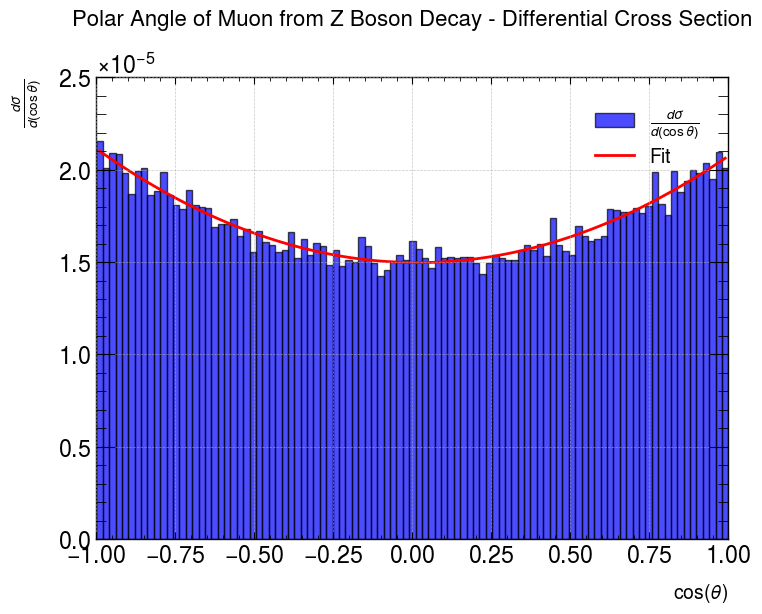

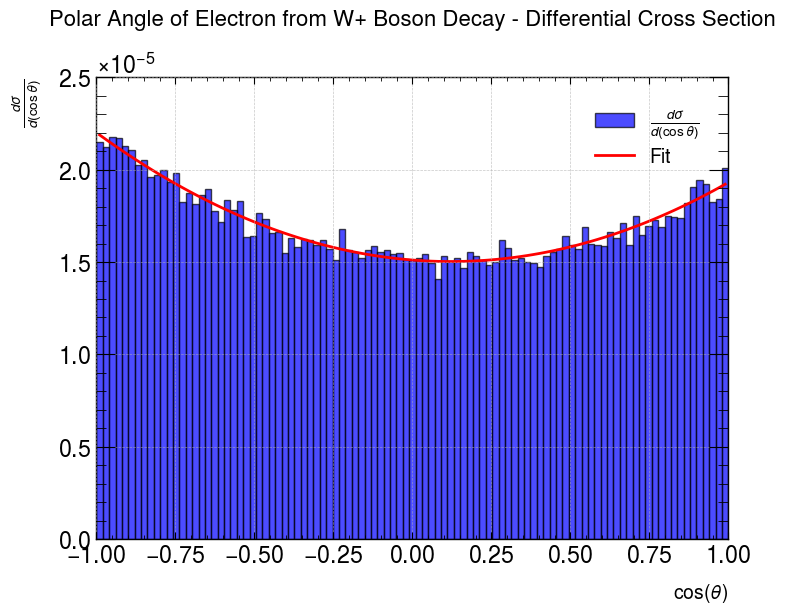

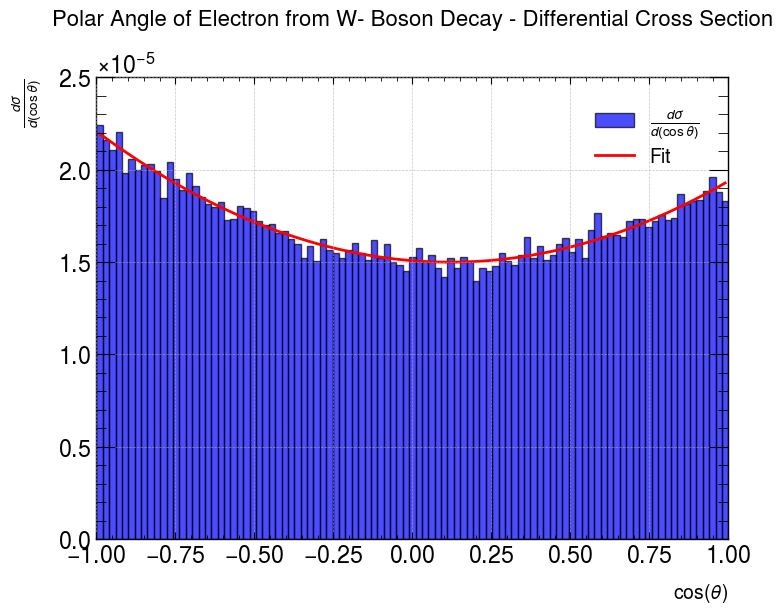

[0.40750452855227354, 0.4153715002023412, 0.1771239712453853]
[0.43252114065995595, 0.3795353138381121, 0.18794354550193196]
[0.3809264741131741, 0.4339211793052997, 0.1851523465815262]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from lmfit import Model

def z_helicity_function(cos_theta, fL, fR, f0):
    cv = -1/2 + 2 * np.sin(0.23152)**2
    ca = -1/2
    alpha = (2 * cv * ca) / (cv**2 + ca**2)
    term1 = (3 / 8) * fL * (1 + 2 * alpha * cos_theta + cos_theta**2)
    term2 = (3 / 8) * fR * (1 + cos_theta**2 - 2 * alpha * cos_theta)
    term3 = (3 / 4) * f0 * (1 - cos_theta**2)
    return term1 + term2 + term3

def w_helicity_function(cos_theta, fL, fR, f0):
    term1 = (3 / 8) * fL * (1 - cos_theta)**2
    term2 = (3 / 8) * fR * (1 + cos_theta)**2
    term3 = (3 / 4) * f0 * (1 - cos_theta**2)
    return term1 + term2 + term3

def anti_w_helicity_function(cos_theta, fL, fR, f0):
    term1 = (3 / 8) * fL * (1 + cos_theta)**2
    term2 = (3 / 8) * fR * (1 - cos_theta)**2
    term3 = (3 / 4) * f0 * (1 - cos_theta**2)
    return term1 + term2 + term3

def calculate_helicity_fractions(data, boson_type, title, file_name):
    luminosity = 100000 / 3.3917389499999996e-05
    valid_data = data[np.isfinite(data)]
    cos_theta_data = np.cos(valid_data)
    cos_theta_bins = np.linspace(-1, 1, 100)
    
    plt.style.use(hep.style.ATLAS)
    plt.figure(figsize=(8, 6))
    
    hist_values, bins, _ = plt.hist(
        cos_theta_data, bins=cos_theta_bins, color='blue', edgecolor='black', alpha=0.7,
        weights=np.ones(len(cos_theta_data)) / (luminosity * (cos_theta_bins[1] - cos_theta_bins[0])),
        label=r'$\frac{d\sigma}{d(\cos \theta)}$'
    )

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # Select the helicity function based on boson type
    if boson_type == "Z":
        helicity_function = z_helicity_function
    elif boson_type == "W+":
        helicity_function = w_helicity_function
    elif boson_type == "W-":
        helicity_function = anti_w_helicity_function
    else:
        raise ValueError("Invalid boson type provided.")
    
    helicity_model = Model(helicity_function)
    
    # Set parameter initial values and bounds
    params = helicity_model.make_params(fL=0.5, fR=0.1, f0=0.1)
    params['fL'].min = 0
    params['fL'].max = 1
    params['fR'].min = 0
    params['fR'].max = 1
    params['f0'].min = 0
    params['f0'].max = 1
    
    # Perform fitting
    result = helicity_model.fit(hist_values, params, cos_theta=bin_centers)
    
    # Normalize the parameters
    total = result.params['fL'].value + result.params['fR'].value + result.params['f0'].value
    normalized_params = [result.params['fL'].value / total, result.params['fR'].value / total, result.params['f0'].value / total]
    
    plt.plot(bin_centers, result.best_fit, color='red', label='Fit', linewidth=2)
    
    # Labeling and titling
    plt.xlabel(r'cos($\theta$)', fontsize=14)
    plt.ylabel(r'$\frac{d\sigma}{d(\cos \theta)}$', fontsize=14)
    plt.title(f"{title} - Differential Cross Section", fontsize=16, pad=20)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Save the plot
    save_path = rf"C:\Users\gabri\OneDrive\Documents\University\Mphys\TriBoson\Week4\Plots\Polarity\{file_name}_histogram.png"
    plt.savefig(save_path, dpi=300)
    plt.show()
    
    return normalized_params

# Example calls with boson type specified as a string
normalized_popt = calculate_helicity_fractions(muon_angles, "Z", "Polar Angle of Muon from Z Boson Decay", "Z_Boson_Differential_Cross_Section_Fit")
normalized_popt_2 = calculate_helicity_fractions(electron_angles, "W+", "Polar Angle of Electron from W+ Boson Decay", "W+_Boson_Differential_Cross_Section_Fit")
normalized_popt_3 = calculate_helicity_fractions(anti_electron_angles, "W-", "Polar Angle of Electron from W- Boson Decay", "W-_Boson_Differential_Cross_Section_Fit")

print(normalized_popt)
print(normalized_popt_2)
print(normalized_popt_3)
